In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
using ForwardDiff

┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1317
┌ Info: Precompiling FileIO [5789e2e9-d7fb-5bc7-8068-2c6fae9b9549]
└ @ Base loading.jl:1317
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1317
┌ Info: Precompiling StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91]
└ @ Base loading.jl:1317
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1317
┌ Info: Precompiling HDF5 [f67ccb44-e63f-5c2f-98bd-6dc0ccc4ba2f]
└ @ Base loading.jl:1317
┌ Info: Precompiling IntervalSets [8197267c-284f-5f27-9208-e0e47529a953]
└ @ Base loading.jl:1317
┌ Info: Precompiling ArraysOfArrays [65a8f2f4-9b39-5baf-92e2-a9cc46fdf018]
└ @ Base loading.jl:1317
┌ Info: Precompiling ValueShapes [136a8f8c-c49b-4edb-8b98-f3d64d48be8f]
└ @ Base loading.jl:1317
┌ Info: Precompiling Measurements [eff96d63-e80a-5855-80a2-b1b0885c5ab7]
└ @ Base loading.jl:1317
┌ Info: Precompiling BAT [c0cd4b16-88b7-57fa-983b

In [2]:
FPATH = "../../data/sampling_results/Benchmark-14/"

function marg_mean_shaped(name)
    smpl_tmp = bat_read(FPATH*name).result
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp = mean(smpl_tmp)
    return smpl_tmp
end

function marg_std_shaped(name)
    smpl_tmp = bat_read(FPATH*name).result
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp = std(smpl_tmp)
    return smpl_tmp
end

function get_emmitance(name, proj)
    # proj  1 / 2 
    smpl_tmp = bat_read(FPATH*name).result
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp, smpl_w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    emm = smpl_tmp[proj,:].*smpl_tmp[1+proj,:].*10^-5 .* 1000 .* 426.0
    μ = mean(emm, FrequencyWeights(smpl_w))
    σ = std(emm, FrequencyWeights(smpl_w)) 
    return (mean = μ, std = σ)
end

get_emmitance (generic function with 1 method)

In [3]:
β1 = 0.015
β2 = 0.0077
β3 = 0.0058

# flat prior for the pixel size
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19),],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), ],
        waist = [truncated(Normal(2.774, 0.03), 2.5, 3.6),],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1.0, 1.0, 1.0], 
        resy = [1.0, 1.0, 1.0], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );  # works  

In [4]:
smpl_tmp = bat_read(FPATH*"hc-56.hdf5").result
smpl_tmp = varshape(prior).(smpl_tmp);

In [5]:
filenames = readdir("../../data/sampling_results/Benchmark-14/")
images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
hc_mask = [i[1:3] == "hc-" for i in filenames]
hc_fnames = filenames[hc_mask]
hc_eind = parse.(Int64, [i[4:end-5] for i in hc_fnames])
hc_charge = images["charge"][hc_eind]
hc_runind = images["ev_ind"][hc_eind];

In [6]:
filenames = readdir("../../data/sampling_results/Benchmark-14/")
images = load("../../data/experiment/dataset_2/m1/images-satur.jld2")
lc_mask = [i[1:3] == "lc-" for i in filenames]
lc_fnames = filenames[lc_mask]
lc_eind = parse.(Int64, [i[4:end-5] for i in lc_fnames])
lc_charge = images["charge"][lc_eind]
lc_runind = images["ev_ind"][lc_eind];

In [7]:
fnames = [lc_fnames; hc_fnames]
charges = Float64[lc_charge; hc_charge]
runind = Int64[lc_runind ; hc_runind]
charges_n = charges ./ maximum(charges)
runind_n = runind ./ maximum(runind);

In [8]:
mean_params =  [marg_mean_shaped(i) for i in fnames];
std_params =  [marg_std_shaped(i) for i in fnames];

In [9]:
length(fnames)

78

In [10]:
tr_size = [i.tr_size[1] for i in mean_params]
ang_spread = [i.ang_spr[1] for i in mean_params]
waist = [i.waist[1] for i in mean_params]
cam4_resx = [i.cam4_resx[1] for i in mean_params]
cam4_resy = [i.cam4_resy[1] for i in mean_params];

In [11]:
mean(charges)

25.92067562005459

In [12]:
emm_tmp_1 = [get_emmitance(i, 1).mean for i in fnames]

mean(emm_tmp_1)

2.232474274659958

In [13]:
@show mean(tr_size),  mean(ang_spread),  mean(waist),  mean(cam4_resx)

(mean(tr_size), mean(ang_spread), mean(waist), mean(cam4_resx)) = (0.11195083740017556, 4.688308104862117, 3.259444452536683, 5.278501279904461)


(0.11195083740017556, 4.688308104862117, 3.259444452536683, 5.278501279904461)

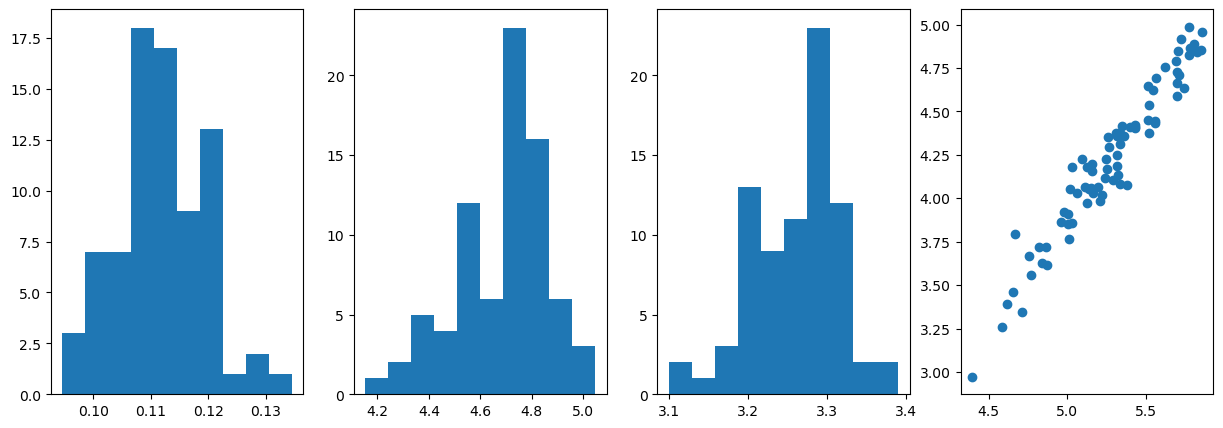

PyObject <matplotlib.collections.PathCollection object at 0x7f66609b0f40>

In [14]:
fig, ax= plt.subplots(1,4, figsize=(15,5))

ax[1].hist(tr_size)
ax[2].hist(ang_spread)
ax[3].hist(waist)
ax[4].scatter(cam4_resx, cam4_resy)